In [51]:
from optimization import gradientDescent, testFunction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [52]:
def display_descent(f, params, lr, iterations, alpha):
    x = params.copy()
    x_prev = params.copy()
    out = []
    for i in range(iterations):
        newParams = gradientDescent(f, x, x_prev, lr, alpha)
        x_prev = x.copy()
        x = newParams.copy()
        out.append(x)
    out = np.array(out)
    plt.plot(out[:, 0], out[:, 1], 'o-')
    plt.show()
    return out

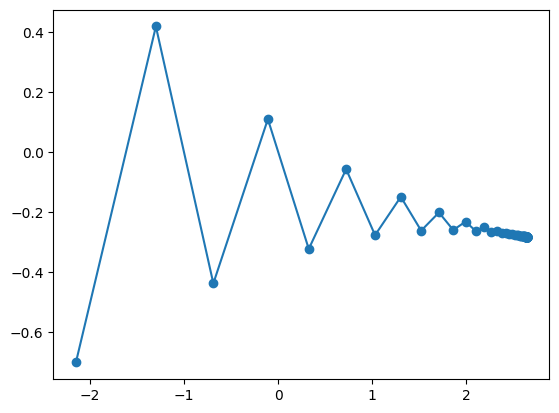

In [53]:
params = display_descent(testFunction, [-3, 1], 0.085, 100, 0)

In [54]:
# Src: https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=787014841
def spherish(params):
    out = 0
    for i in range(len(params)):
        out += params[i] * params[i]
    return out

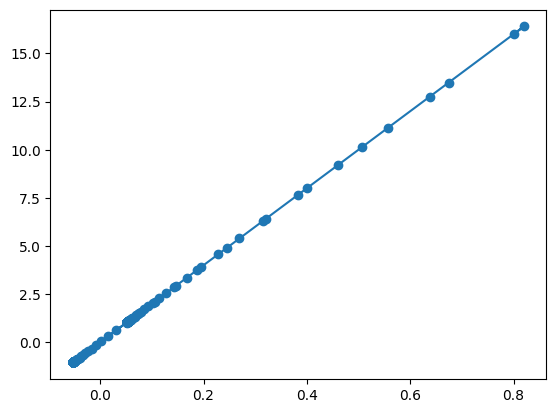

In [55]:
params = display_descent(spherish, [1, 20], 0.1, 1000, 0.9)

In [56]:
# Src: https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=787014841
def rosenbrock(params):
    out = 0
    for i in range(len(params) - 1):
        out += 100 * (params[i + 1] - params[i] * params[i]) * (params[i + 1] - params[i] * params[i]) + (params[i] - 1) * (params[i] - 1)
    return out

In [57]:
import toyml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

In [58]:
random.seed(42)

In [59]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def create_random_matrix(rows, cols):
    a = np.random.rand(rows, cols)
    return toyml.Matrix(a)

def create_random_vector(size):
    a = np.random.rand(size)
    return toyml.Vector(a)

last_loss = 0
def mean_squared_error(a):
    global last_loss
    last_loss = np.mean(a ** 2)
    return last_loss

In [60]:
#NeuralNetwork(vector<Matrix> weights, vector<Vector> biases, vector<function<double(double)>> activations)
def create_titanic_model(lyrs=[8, 8]):    
    weights = []
    biases = []
    activations = []
    
    # Create first layer - size of the input
    weights.append(create_random_matrix(lyrs[0], lyrs[1]))
    biases.append(create_random_vector(lyrs[0]))
    activations.append(sigmoid)
    
    # Create hidden layers
    for i in range(1, len(lyrs)):
        weights.append(create_random_matrix(lyrs[i], lyrs[i-1]))
        biases.append(create_random_vector(lyrs[i]))
        activations.append(sigmoid)

    # create output layer
    weights.append(create_random_matrix(1, lyrs[-1]))
    biases.append(create_random_vector(1))
    activations.append(sigmoid)
    
    return toyml.NeuralNetwork(weights, biases, activations)

In [61]:
# Load the data
# This is a simple implementation of training on the titanic dataset
train = pd.read_csv('train titanic.csv')
test = pd.read_csv('test titanic.csv')
df = pd.concat([train, test], axis=0, sort=True)

def preprocess(df):
    df['Sex'] = df['Sex'].astype('category')
    df['Sex'] = df['Sex'].cat.codes
    categorical = ['Embarked']
    for var in categorical:
        df = pd.concat([df, pd.get_dummies(df[var], prefix=var)], axis=1)
        del df[var]
    df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
    continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp']
    scaler = StandardScaler()
    for var in continuous:
        df[var] = df[var].astype('float64')
        df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))
    return df

df = preprocess(df)

y_train = df[pd.notnull(df['Survived'])]['Survived']
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

In [62]:
# Training on titanic dataset
model = create_titanic_model()
X = [toyml.Vector(x) for x in X_train.values.tolist()]
y = [toyml.Vector([x]) for x in y_train.values.tolist()]
print(len(X), len(y))

891 891


In [63]:
EPOCHS = 10
BATCH_SIZE = 30
for i in range(EPOCHS):
    for k in range(0, len(X), BATCH_SIZE):
        # inputs: vector<Vector> X, vector<Vector> y, double learning_rate, int epochs, function<double(double)> loss
        model.fit(X[k:k+BATCH_SIZE], y[k:k+BATCH_SIZE], 0.01, 1, mean_squared_error)

for index, row in df.iterrows():
    model.predict(toyml.Vector(row)).to_vector()

# Inference: 13.9 seconds

In [68]:
def create_linear_predictor(k=1):
    bias = random.random()
    weights = create_random_vector(k)
    return toyml.LinearPredictor(weights, bias)

In [ ]:
# 1D linear regression
np.random.seed(42)
X = np.random.uniform(0, 100, 150)
y = 3 * X + np.random.normal(0, 10, 150)

linear_predictor = create_linear_predictor()
X = [toyml.Vector([x]) for x in X]
y = [toyml.Vector([x]) for x in y]
linear_predictor.fit(X, y, 0.01, 100, mean_squared_error)

In [ ]:
# 2D linear regression
np.random.seed(42)
X = np.random.uniform(0, 100, (150, 2))
y = 3 * X[:, 0] + 2 * X[:, 1] + np.random.normal(0, 10, 150)

linear_predictor = create_linear_predictor(2)
X = [toyml.Vector(x) for x in X]
y = [toyml.Vector([x]) for x in y]
linear_predictor.fit(X, y, 0.01, 100, mean_squared_error)

In [ ]:
pca = toyml.PCA(n_components=2)
X_pca = pca.fit_transform(X_train.values)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Titanic Dataset')
plt.show()

In [ ]:
# Import SVM from toyml
from toyml import SVMs

# Train SVM on the Titanic dataset
svm = SVMs(kernel='linear')
svm.fit(X_train.values, y_train.values)